# PyTorch神经网络搭建

在这个文件中，我们讲解使用PyTorch搭建和训练神经网络的基本方法。
我们以PyTorch官方的tutorial为例：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## 下载数据集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 如果无法正常下载数据，则加上以下两行代码
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


C:\Users\Jiash\anaconda3\envs\env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


170499072it [00:17, 9509462.49it/s]                                


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


以下链接是对我们所使用的数据集CIFAR-10的介绍。
https://www.cs.toronto.edu/~kriz/cifar.html

CIFAR1-10数据集包括60000张32×32的分为10类的图片，每一类由6000张。期中，50000张是训练数据，10000张是测试数据。

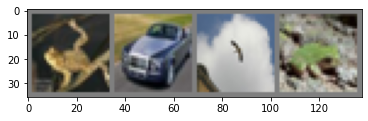

frog  car   bird  frog 


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## 搭建神经网络

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 选择损失函数和optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 实现神经网路的训练

In [5]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.187
[1,  4000] loss: 1.873
[1,  6000] loss: 1.702
[1,  8000] loss: 1.594
[1, 10000] loss: 1.527
[1, 12000] loss: 1.458
[2,  2000] loss: 1.408
[2,  4000] loss: 1.371
[2,  6000] loss: 1.338
[2,  8000] loss: 1.318
[2, 10000] loss: 1.292
[2, 12000] loss: 1.280
Finished Training


## 保存模型

In [6]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 加载模型

In [7]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 测试模型的准确性

In [8]:
correct_pred = {}
total_pred = {}
for classname in classes:
    correct_pred[classname] = 0
    total_pred[classname] = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.8 %
Accuracy for class: car   is 66.6 %
Accuracy for class: bird  is 38.9 %
Accuracy for class: cat   is 45.4 %
Accuracy for class: deer  is 60.0 %
Accuracy for class: dog   is 43.4 %
Accuracy for class: frog  is 62.5 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 63.0 %
Accuracy for class: truck is 57.5 %
